The objective of this notebook is to patch together reservoir models from the previously generated and selected training images. These reservoir models are output as ready to run for full flow simulations

In [2]:
import numpy as np
import pandas as pd
import plotly.io as pio
import sys
import os
import random 
import datetime
import pathlib
import matplotlib.pyplot as plt
from matplotlib import cm
import plotly.express as px
# from GRDECL_file_reader.GRDECL2VTK import*
import time
import datetime
plt.style.use('plot_style.txt')
sys.path.append("../")
pio.renderers.default = "browser"


In [578]:
def setup_TI_zones(crest_start_min,crest_start_max,crest_end_min,crest_end_max,
                    transition_zone_crest_start_min,transition_zone_crest_start_max,
                    transition_zone_crest_end_min,transition_zone_crest_end_max):
    """ setup of ranges for TI zones to start/end and their transition zone width"""
    
    crest_start = random.randint(crest_start_min,crest_start_max)
    crest_end = random.randint(crest_end_min,crest_end_max)
    transition_zone_crest_start = random.randint(transition_zone_crest_start_min,transition_zone_crest_start_max)
    transition_zone_crest_end = random.randint(transition_zone_crest_end_min,transition_zone_crest_end_max)

    # set up TI_zone env
    # generate 2D mesh
    x = np.arange(0,200+1,1,)
    y = np.arange(0,100+1,1)
    x_grid, y_grid = np.meshgrid(x,y)
    #get cell centers of mesh
    x_cell_center = x_grid[:-1,:-1]+0.5
    y_cell_center = y_grid[:-1,:-1]+0.5
    TI_zones = []
    TI_zones_all = []
    for y in range(x_cell_center.shape[0]):
        for x in range(len(x_cell_center[1])):
            if crest_start + transition_zone_crest_start  <= x_cell_center[y,x] <=crest_end - transition_zone_crest_end:
                TI_zones.append(0)
            elif crest_start - transition_zone_crest_start  <= x_cell_center[y,x]<=crest_end + transition_zone_crest_end:
                TI_zones.append(random.randint(0,1))
    #         elif crest_end - transition_zone_crest_end  >= x_cell_center[y,x]:
    #             TI_zones.append(1)
            else:
    #             TI_zones.append(random.randint(0,1))
                TI_zones.append(1)

    #             TI_zones.append(5)

    # extent to full 3D reservoir model. so far only have 1 layer
    TI_zones_all = []
    for i in range(Z):
        TI_zones_all.extend(TI_zones)
    TI_zones_all = np.array(TI_zones_all).reshape((200,100,7))
    
    return TI_zones_all, TI_zones,crest_start,crest_end,transition_zone_crest_start,transition_zone_crest_end

In [579]:
def save_reservoir_model_properties(base_path,dataset,model_id,prop):
    """ save properties of patched reservoir model so that they can be run with FD"""


    file_path = base_path + '/INCLUDE/{}/M{}.GRDECL'.format(prop,model_id)

    file_beginning = "FILEUNIT\nMETRIC /\n\n{}\n".format(prop)
    dataset[-1] = "{} /".format(dataset[-1])
    dataset = ["{} ".format(str(element)) for element in dataset]

    skipline = "\n"
    newline_ticker = 50
    datset_newlines = []
    for idx, ele in enumerate(dataset):

        # if index multiple of N
        if idx % newline_ticker == 0:
            datset_newlines.append(skipline)
        datset_newlines.append(ele)

    fil = open(file_path,"w+")
    fil.writelines(file_beginning)
    fil.writelines(datset_newlines)
    fil.close()



In [580]:
def built_data_files(base_path,model_id):
    """ built Data files to run FD and full flow simulations on """

    file_path = base_path + '/DATA/M{}.DATA'.format(model_id)
    data_file = "RUNSPEC\n\nTITLE\nModel_{}\n\nDIMENS\n--NX NY NZ\n200 100 7 /\n\n--Phases\nOIL\nWATER\n\n--DUALPORO\n--NODPPM\n\n--Units\nMETRIC\n\n--Number of Saturation Tables\nTABDIMS\n1 /\n\n--Maximum number of Wells\nWELLDIMS\n10 100 5 10 /\n\n--First Oil\nSTART\n1 OCT 2017 /\n\n--Memory Allocation\nNSTACK\n100 /\n\n--How many warnings allowed, but terminate after first error\nMESSAGES\n11*5000 1 /\n\n--Unified Output Files\nUNIFOUT\n\n--======================================================================\n\nGRID\n--Include corner point geometry model\nINCLUDE\n'..\INCLUDE\GRID.GRDECL'\n/\n\nACTNUM\n140000*1 /\n\n--Porosity\nINCLUDE\n'..\INCLUDE\PORO\M{}.GRDECL'\n/\n\n--Permeability\nINCLUDE\n'..\INCLUDE\PERMX\M{}.GRDECL'\n/\nINCLUDE\n'..\INCLUDE\PERMY\M{}.GRDECL'\n/\nINCLUDE\n'..\INCLUDE\PERMZ\M{}.GRDECL'\n/\n\n--Net to Gross\nNTG\n140000*1\n/\n\n--Output .INIT file to allow viewing of grid data in post proessor\nINIT\n\n--======================================================================\n\nPROPS\n\nINCLUDE\n'..\INCLUDE\DP_pvt.inc' /\n\nINCLUDE\n'..\INCLUDE\ROCK_RELPERMS.INC' /\n\n--======================================================================\n\nREGIONS\n\nEQLNUM\n140000*1\n/\nSATNUM\n140000*1\n/\nPVTNUM\n140000*1\n/\n\n--======================================================================\n\nSOLUTION\n\nINCLUDE\n'..\INCLUDE\SOLUTION.INC' /\n\n--======================================================================\n\nSUMMARY\n\nINCLUDE\n'..\INCLUDE\SUMMARY.INC' /\n\n--======================================================================\n\nSCHEDULE\n\nINCLUDE\n'..\INCLUDE\SCHEDULE.INC' /\n\nEND".format(model_id,model_id,model_id,model_id,model_id)  

    file = open(file_path, "w+")
    # write petrelfilepath and licence part into file and seed
    file.write(data_file)

    # close file
    file.close()

In [581]:
def load_training_images(base_path,number_training_image_zones,number_training_images_per_zone,X,Y,Z):
        """ upload all training images that are to be used for reservoir model building 1 training image = entire reservoir model. """
        t_igrid = time.time()
        print('=======loading training images=========')

        # arrays for storage of TI: N_TI_zones, N_TI_per_zone, N_values_per_TI
        TI_values_permx = np.empty((number_training_image_zones,number_training_images_per_zone,(X*Y*Z)))
        TI_values_permx[:] = np.nan
        TI_values_permy = np.empty((number_training_image_zones,number_training_images_per_zone,(X*Y*Z)))
        TI_values_permy[:] = np.nan
        TI_values_permz = np.empty((number_training_image_zones,number_training_images_per_zone,(X*Y*Z)))
        TI_values_permz[:] = np.nan
        TI_values_poro = np.empty((number_training_image_zones,number_training_images_per_zone,(X*Y*Z)))
        TI_values_poro[:] = np.nan

        # set up path etc. to allow to extract grdcel file models into np arrays.
        geomodel_path = str(base_path + "training_images/TI_1/INCLUDE/GRID.grdecl")
        GRID = GeologyModel(filename = geomodel_path)

        # load each model into storage array
        for TI_zone in range(number_training_image_zones):
            for TI_no in range(number_training_images_per_zone):
                permx_path = str(base_path + 'training_images/TI_{}/INCLUDE/PERMX/M{}.GRDECL'.format(TI_zone,TI_no))
                permy_path = str(base_path + 'training_images/TI_{}/INCLUDE/PERMY/M{}.GRDECL'.format(TI_zone,TI_no))
                permz_path = str(base_path + 'training_images/TI_{}/INCLUDE/PERMZ/M{}.GRDECL'.format(TI_zone,TI_no))
                poro_path = str(base_path +'training_images/TI_{}/INCLUDE/PORO/M{}.GRDECL'.format(TI_zone,TI_no))

                permx = GRID.LoadCellData(varname="PERMX",filename=permx_path)
                permy = GRID.LoadCellData(varname="PERMY",filename=permy_path)
                permz = GRID.LoadCellData(varname="PERMZ",filename=permz_path)
                poro = GRID.LoadCellData(varname="PORO",filename=poro_path)

                TI_values_permx[TI_zone,TI_no,:] = permx
                TI_values_permy[TI_zone,TI_no,:] = permy
                TI_values_permz[TI_zone,TI_no,:] = permz
                TI_values_poro[TI_zone,TI_no,:] = poro
        
        print("Training images loaded! -  took {0:2.2f} seconds".format(time.time()-t_igrid))

        return TI_values_permx,TI_values_permy,TI_values_permz,TI_values_poro


In [588]:
def load_training_images_truth_case(base_path,X,Y,Z):
        """ upload all training images that are to be used for reservoir model building 1 training image = entire reservoir model. """
        t_igrid = time.time()
        print('=======loading training images=========')

        # arrays for storage of TI: N_TI_zones, N_TI_per_zone, N_values_per_TI
        TI_values_permx = np.empty((2,1,(X*Y*Z)))
        TI_values_permx[:] = np.nan
        TI_values_permy = np.empty((2,1,(X*Y*Z)))
        TI_values_permy[:] = np.nan
        TI_values_permz = np.empty((2,1,(X*Y*Z)))
        TI_values_permz[:] = np.nan
        TI_values_poro = np.empty((2,1,(X*Y*Z)))
        TI_values_poro[:] = np.nan

        # set up path etc. to allow to extract grdcel file models into np arrays.
        geomodel_path = str(base_path + "training_images/TI_1/INCLUDE/GRID.grdecl")
        GRID = GeologyModel(filename = geomodel_path)

        # load crest into storage array
        permx_path = str(base_path + 'training_images/TI_0/INCLUDE/PERMX/M_truth_crest.GRDECL')
        permy_path = str(base_path + 'training_images/TI_0/INCLUDE/PERMY/M_truth_crest.GRDECL')
        permz_path = str(base_path + 'training_images/TI_0/INCLUDE/PERMZ/M_truth_crest.GRDECL')
        poro_path = str(base_path +'training_images/TI_0/INCLUDE/PORO/M_truth_crest.GRDECL')

        permx = GRID.LoadCellData(varname="PERMX",filename=permx_path)
        permy = GRID.LoadCellData(varname="PERMY",filename=permy_path)
        permz = GRID.LoadCellData(varname="PERMZ",filename=permz_path)
        poro = GRID.LoadCellData(varname="PORO",filename=poro_path)

        TI_values_permx[0,0,:] = permx
        TI_values_permy[0,0,:] = permy
        TI_values_permz[0,0,:] = permz
        TI_values_poro[0,0,:] = poro
        
        # load flank into storage array
        permx_path = str(base_path + 'training_images/TI_1/INCLUDE/PERMX/M_truth_flank.GRDECL')
        permy_path = str(base_path + 'training_images/TI_1/INCLUDE/PERMY/M_truth_flank.GRDECL')
        permz_path = str(base_path + 'training_images/TI_1/INCLUDE/PERMZ/M_truth_flank.GRDECL')
        poro_path = str(base_path +'training_images/TI_1/INCLUDE/PORO/M_truth_flank.GRDECL')

        permx = GRID.LoadCellData(varname="PERMX",filename=permx_path)
        permy = GRID.LoadCellData(varname="PERMY",filename=permy_path)
        permz = GRID.LoadCellData(varname="PERMZ",filename=permz_path)
        poro = GRID.LoadCellData(varname="PORO",filename=poro_path)

        TI_values_permx[1,0,:] = permx
        TI_values_permy[1,0,:] = permy
        TI_values_permz[1,0,:] = permz
        TI_values_poro[1,0,:] = poro
        
        print("Training images loaded! -  took {0:2.2f} seconds".format(time.time()-t_igrid))

        return TI_values_permx,TI_values_permy,TI_values_permz,TI_values_poro


In [583]:
def built_and_save_patched_reservoir_models(n_models,number_training_images_per_zone,TI_values_permx,TI_values_permy,TI_values_permz,TI_values_poro):
    """built and save models taht are ready for full flow simulations. 
       The models are a random combination of training images from crest and flank."""
    
    TI_ID_crest_used = []
    TI_ID_flank_used = []
    crest_start_used = []
    crest_end_used = []
    transition_zone_crest_start_used = []
    transition_zone_crest_end_used = []
    for model_id in range(n_models):
        
        # make TI zones
        TI_zones_all, TI_zones,crest_start,crest_end,transition_zone_crest_start,transition_zone_crest_end = setup_TI_zones(crest_start_min = 65,crest_start_max  = 75,crest_end_min =125,crest_end_max = 135,
                                                                                    transition_zone_crest_start_min = 1,transition_zone_crest_start_max = 10,
                                                                                    transition_zone_crest_end_min = 1,transition_zone_crest_end_max = 10)
    
        crest_start_used.append(crest_start)
        crest_end_used.append(crest_end)
        transition_zone_crest_start_used.append(transition_zone_crest_start)
        transition_zone_crest_end_used.append(transition_zone_crest_end)
        
        # assign TI ID to each point in grid
        random_TI_crest = random.randint(0,number_training_images_per_zone-1)
        random_TI_flank = random.randint(0,number_training_images_per_zone-1)
        TI_ID_crest_used.append(random_TI_crest)
        TI_ID_flank_used.append(random_TI_flank)
        TI_ID_all = np.where(TI_zones_all ==0,random_TI_crest,random_TI_flank)
        
        # Patch together reservoir model 
        patch_permx  = []
        patch_permy  = []
        patch_permz  = []
        patch_poro  = []

        TI_ID_all_flatten = TI_ID_all.flatten()
        TI_zones_all_flatten = TI_zones_all.flatten()

        for i in range(len(TI_ID_all_flatten)):

            TI_zone = int(TI_zones_all_flatten[i])
            TI_no = int(TI_ID_all_flatten[i])

            permx = TI_values_permx[TI_zone,TI_no,i]
            permy = TI_values_permy[TI_zone,TI_no,i]              
            permz = TI_values_permz[TI_zone,TI_no,i]              
            poro = TI_values_poro[TI_zone,TI_no,i]

            patch_permx.append(permx)
            patch_permy.append(permy)
            patch_permz.append(permz)
            patch_poro.append(poro)
        
        save_reservoir_model_properties(base_path,patch_permx,model_id,"PERMX")
        save_reservoir_model_properties(base_path,patch_permy,model_id,"PERMY")
        save_reservoir_model_properties(base_path,patch_permz,model_id,"PERMZ")
        save_reservoir_model_properties(base_path,patch_poro,model_id,"PORO")
        built_data_files(base_path,model_id)
        
    crest_start,crest_end,transition_zone_crest_start,transition_zone_crest_end
    # store TI combis used in list and export to csv.
    df = pd.DataFrame({'Flank_TI_ID':TI_ID_flank_used,"Crest_TI_ID":TI_ID_crest_used,
                       "crest_start":crest_start_used,"crest_end":crest_end_used,
                       "transition_zone_crest_start":transition_zone_crest_start_used,
                      "transition_zone_crest_end":transition_zone_crest_end_used})
    df.to_csv(base_path+'TI_combinations.csv')
    print("the reservoir models are now ready for full flow simulation and can be found here : {}".format(base_path))
        

In [586]:
def built_and_save_truth_case_reservoir_model(TI_values_permx,TI_values_permy,TI_values_permz,TI_values_poro):
    """built and save models taht are ready for full flow simulations. 
       The models are a random combination of training images from crest and flank."""
   
    model_id = "Truth_Case"
        
    # make TI zones
    TI_zones_all, TI_zones,crest_start,crest_end,transition_zone_crest_start,transition_zone_crest_end = setup_TI_zones(crest_start_min = 63,crest_start_max  = 63,crest_end_min =128,crest_end_max = 128,
                                                                                transition_zone_crest_start_min = 7,transition_zone_crest_start_max = 7,
                                                                                transition_zone_crest_end_min = 3,transition_zone_crest_end_max = 3)

    # assign TI ID to each point in grid
#     TI_crest = 379
#     TI_flank = 190
    TI_crest = 0
    TI_flank = 0

    TI_ID_all = np.where(TI_zones_all ==0,TI_crest,TI_flank)

    # Patch together reservoir model 
    patch_permx  = []
    patch_permy  = []
    patch_permz  = []
    patch_poro  = []

    TI_ID_all_flatten = TI_ID_all.flatten()
    TI_zones_all_flatten = TI_zones_all.flatten()

    for i in range(len(TI_ID_all_flatten)):

        TI_zone = int(TI_zones_all_flatten[i])
        TI_no = int(TI_ID_all_flatten[i])

        permx = TI_values_permx[TI_zone,TI_no,i]
        permy = TI_values_permy[TI_zone,TI_no,i]              
        permz = TI_values_permz[TI_zone,TI_no,i]              
        poro = TI_values_poro[TI_zone,TI_no,i]

        patch_permx.append(permx)
        patch_permy.append(permy)
        patch_permz.append(permz)
        patch_poro.append(poro)

    save_reservoir_model_properties(base_path,patch_permx,model_id,"PERMX")
    save_reservoir_model_properties(base_path,patch_permy,model_id,"PERMY")
    save_reservoir_model_properties(base_path,patch_permz,model_id,"PERMZ")
    save_reservoir_model_properties(base_path,patch_poro,model_id,"PORO")
    built_data_files(base_path,model_id)

    print("the reservoir models are now ready for full flow simulation and can be found here : {}".format(base_path))
        

### Import data

In [269]:
base_path = "C:/AgentBased_RM/Output/Training_image_models_chapter_3/"

number_training_image_zones = 2
number_training_images_per_zone = 20
X = 200
Y = 100
Z = 7

In [591]:
TI_values_permx,TI_values_permy,TI_values_permz,TI_values_poro = load_training_images(base_path,number_training_image_zones,number_training_images_per_zone,X,Y,Z)
## truth case
TI_values_permx_truth,TI_values_permy_truth,TI_values_permz_truth,TI_values_poro_truth = load_training_images_truth_case(base_path,X,Y,Z)


=======loading training images=========
Training images loaded! -  took 27.44 seconds
=======loading training images=========
Training images loaded! -  took 3.15 seconds


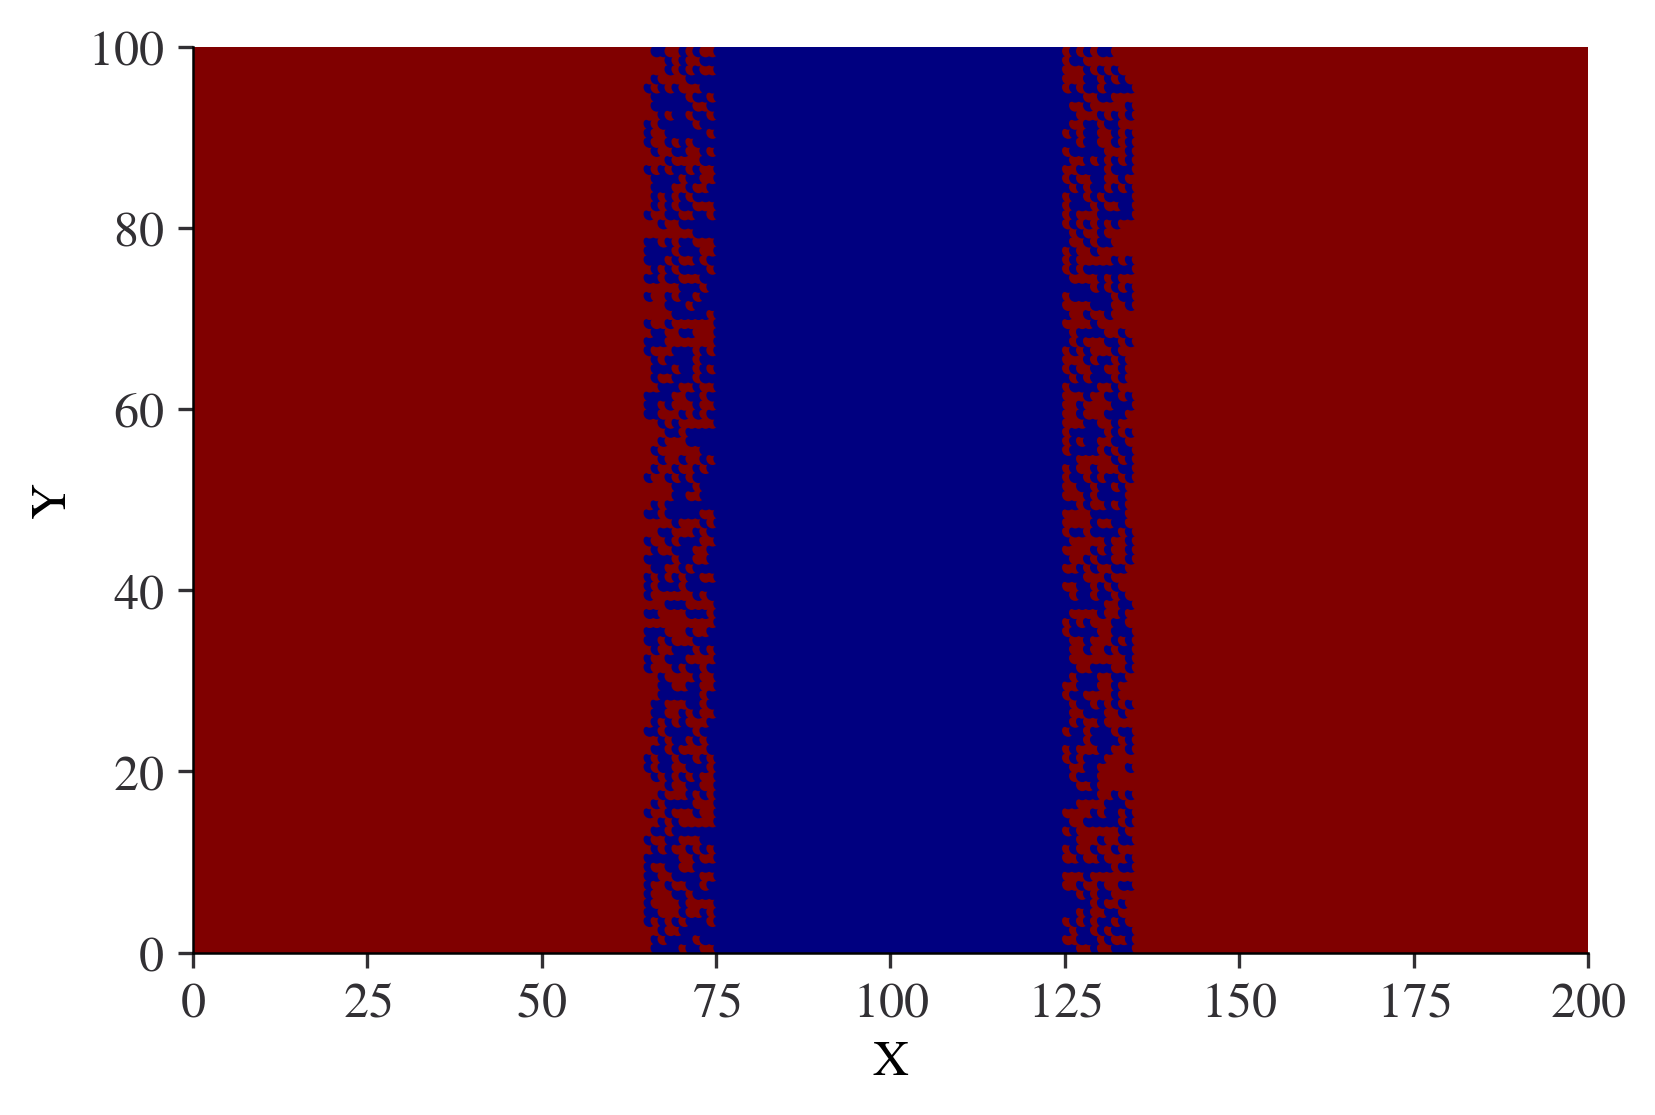

In [339]:
N = 50
# define the colormap
cmap = plt.cm.jet
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# create the new map
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)
viridis = cm.get_cmap('jet', 5)
TI_zones_all, TI_zones,a,b,c,d = setup_TI_zones(crest_start_min = 70,crest_start_max  = 70,crest_end_min =130,crest_end_max = 130,
                    transition_zone_crest_start_min = 5,transition_zone_crest_start_max = 5,
                    transition_zone_crest_end_min = 5,transition_zone_crest_end_max = 5)
# array to assign polygon to cell id
plt.scatter(x_cell_center,y_cell_center, c = TI_zones,marker=".",cmap=viridis,edgecolors = "none"
)
# plt.title("Voronoi Polygons to Grid")
plt.xlim([0,200])
plt.ylim([0,100])
plt.xlabel("X")
plt.ylabel("Y")
plt.savefig('example_zone_extend.png', bbox_inches='tight',dpi = 300)

### Built n patched together reservoir models and truth case

In [271]:
n_models = 100
built_and_save_patched_reservoir_models(n_models,number_training_images_per_zone,TI_values_permx,TI_values_permy,TI_values_permz,TI_values_poro)


the reservoir models are now ready for full flow simulation and can be found here : C:/AgentBased_RM/Output/Training_image_models_chapter_3/


In [594]:
# built truth case
built_and_save_truth_case_reservoir_model(TI_values_permx_truth,TI_values_permy_truth,TI_values_permz_truth,TI_values_poro_truth)


the reservoir models are now ready for full flow simulation and can be found here : C:/AgentBased_RM/Output/Training_image_models_chapter_3/


In [ ]:
built_and_save_patched_reservoir_models(n_models,number_training_images_per_zone,TI_values_permx,TI_values_permy,TI_values_permz,TI_values_poro)


### load production graphs

In [1]:
results_producer = pd.read_csv('results_producer_2.txt',sep="\t")
# remove special character
results_producer.columns = results_producer.columns.str.replace(' ', '')
results_producer.columns = results_producer.columns.str.replace('[', "_")
results_producer.columns = results_producer.columns.str.replace(']', "_")
results_producer.columns = results_producer.columns.str.replace('.DATA', "")
results_producer.columns = results_producer.columns.str.replace(',', "")
results_producer.columns = results_producer.columns.str.replace('', "")
results_producer.columns = results_producer.columns.str.replace('/', "")
results_producer.columns = results_producer.columns.str.replace('.', "")

results_injectors = pd.read_csv('results_injectors.txt',sep="\t")
# remove special character
results_injectors.columns = results_injectors.columns.str.replace(' ', '')
results_injectors.columns = results_injectors.columns.str.replace('[', "_")
results_injectors.columns = results_injectors.columns.str.replace(']', "_")
results_injectors.columns = results_injectors.columns.str.replace('.DATA', "")
results_injectors.columns = results_injectors.columns.str.replace(',', "")
results_injectors.columns = results_injectors.columns.str.replace('', "")
results_injectors.columns = results_injectors.columns.str.replace('/', "")
results_injectors.columns = results_injectors.columns.str.replace('.', "")


# Select the ones you want
Oil_rate = results_producer.loc[:, results_producer.columns.str.startswith('OilRate_')]
Water_rate = results_producer.loc[:, results_producer.columns.str.startswith('WaterRate_')]
Water_rate_inj = results_injectors.loc[:, results_injectors.columns.str.startswith('WaterRate_')]

Oil_total = results_producer.loc[:, results_producer.columns.str.startswith('OilTotal_')]
Water_total = results_producer.loc[:, results_producer.columns.str.startswith('WaterTotal_')]
Watercut = results_producer.loc[:, results_producer.columns.str.startswith('Watercut_')]

# date
Date = results_producer.loc[:, results_producer.columns.str.startswith('Date')]
Date['Date']= pd.to_datetime(Date['Date'],dayfirst=True)



NameError: name 'pd' is not defined

In [683]:
Pore_volume = pd.read_csv("Pore_volume.txt",sep = "\t")
Pore_volume.columns = Pore_volume.columns.str.replace(' ', '')
Pore_volume.columns = Pore_volume.columns.str.replace('[', "_")
Pore_volume.columns = Pore_volume.columns.str.replace(']', "_")
Pore_volume.columns = Pore_volume.columns.str.replace('.DATA', "")
Pore_volume.columns = Pore_volume.columns.str.replace(',', "")
Pore_volume.columns = Pore_volume.columns.str.replace('', "")
Pore_volume.columns = Pore_volume.columns.str.replace('/', "")
Pore_volume.columns = Pore_volume.columns.str.replace('.', "")
Pore_volume.drop(columns =['Date'],inplace = True)
Pore_volume.reset_index(drop=True,inplace = True)

Water_injection_total = pd.read_csv("Water_injection.txt",sep = "\t")
Water_injection_total.columns = Water_injection_total.columns.str.replace(' ', '')
Water_injection_total.columns = Water_injection_total.columns.str.replace('[', "_")
Water_injection_total.columns = Water_injection_total.columns.str.replace(']', "_")
Water_injection_total.columns = Water_injection_total.columns.str.replace('.DATA', "")
Water_injection_total.columns = Water_injection_total.columns.str.replace(',', "")
Water_injection_total.columns = Water_injection_total.columns.str.replace('', "")
Water_injection_total.columns = Water_injection_total.columns.str.replace('/', "")
Water_injection_total.columns = Water_injection_total.columns.str.replace('.', "")
Water_injection_total.drop(columns =['Date'],inplace = True)
Water_injection_total = Water_injection_total.iloc[[-1]]
Water_injection_total.reset_index(drop=True,inplace = True)
Water_injection_total.columns = Water_injection_total.columns.str.replace(' ', '')

Water_injection_total = Water_injection_total.loc[:, Water_injection_total.columns.str.startswith('WaterInjection')]

Porevolume_injected = Water_injection_total.div(Pore_volume.values)

Oil_in_place = pd.read_csv("Oil_in_place.txt",sep = "\t")
Oil_in_place.columns = Oil_in_place.columns.str.replace(' ', '')
Oil_in_place.columns = Oil_in_place.columns.str.replace('[', "_")
Oil_in_place.columns = Oil_in_place.columns.str.replace(']', "_")
Oil_in_place.columns = Oil_in_place.columns.str.replace('.DATA', "")
Oil_in_place.columns = Oil_in_place.columns.str.replace(',', "")
Oil_in_place.columns = Oil_in_place.columns.str.replace('', "")
Oil_in_place.columns = Oil_in_place.columns.str.replace('/', "")
Oil_in_place.columns = Oil_in_place.columns.str.replace('.', "")
OIP_start_end = Oil_in_place.iloc[[0, -1]]
OIP_start_end.drop(columns =['Date'],inplace = True)
OIP_start_end.loc['recovery_factor'] = (1-OIP_start_end.iloc[1] / OIP_start_end.iloc[0]) * 100


C:\Users\bs48\AppData\Local\Continuum\anaconda_3\envs\ABRM\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\bs48\AppData\Local\Continuum\anaconda_3\envs\ABRM\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### Get P10 P50 P90

In [596]:
Quantile_calculator = Oil_total[-1:].T
Quantile_calculator = Quantile_calculator.rename(columns={118: 'Oil_total'})
Quantile_calculator = Quantile_calculator.sort_values(by ="Oil_total")

In [597]:
P10 = Quantile_calculator.quantile(q=0.1, axis=0, numeric_only=True, interpolation='linear').to_numpy()
P50 = Quantile_calculator.quantile(q=0.5, axis=0, numeric_only=True, interpolation='linear').to_numpy()
P90 = Quantile_calculator.quantile(q=0.9, axis=0, numeric_only=True, interpolation='linear').to_numpy()

In [598]:
P10_clostest = Quantile_calculator.iloc[(Quantile_calculator["Oil_total"]-P10).abs().argsort()[:1]]
P50_clostest = Quantile_calculator.iloc[(Quantile_calculator["Oil_total"]-P50).abs().argsort()[:1]]
P90_clostest = Quantile_calculator.iloc[(Quantile_calculator["Oil_total"]-P90).abs().argsort()[:1]]

### Plot

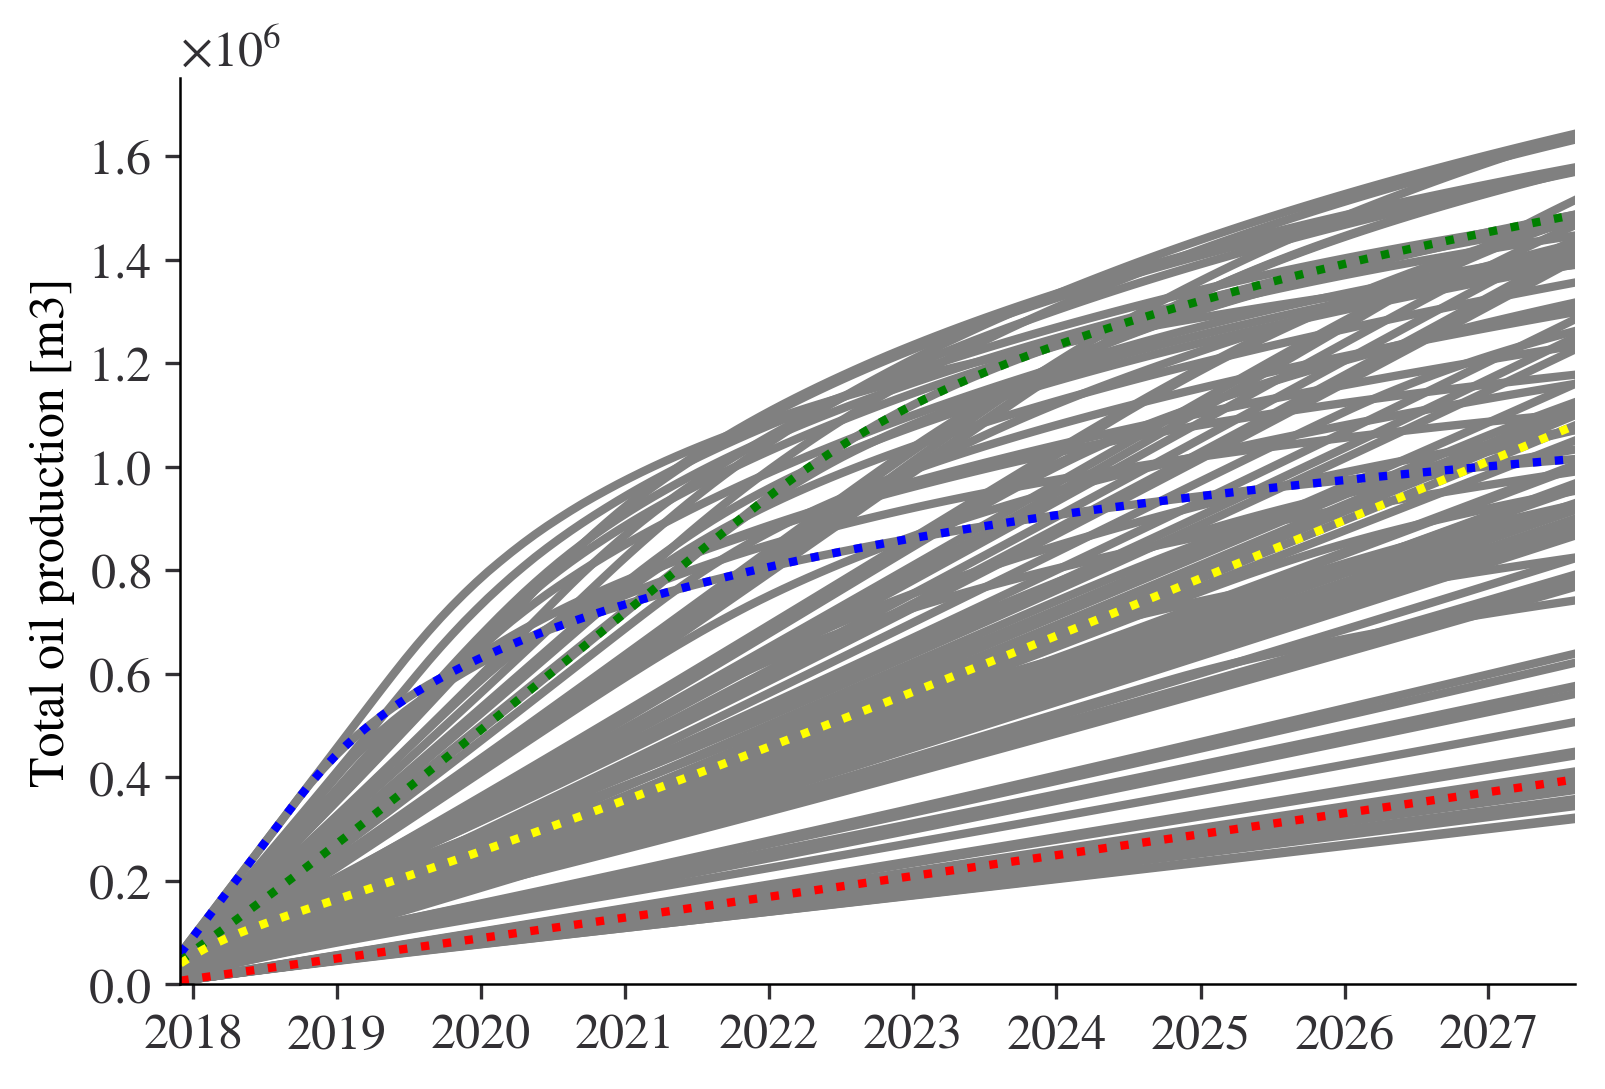

In [603]:
plt.plot(Date.Date,Oil_total,"gray")
plt.plot(Date.Date,Oil_total.OilTotal_M27sdata_sm3,"red",linestyle = 'dotted',linewidth=2)
plt.plot(Date.Date,Oil_total.OilTotal_M65sdata_sm3,"blue",linestyle = 'dotted',linewidth=2)
plt.plot(Date.Date,Oil_total.OilTotal_M62sdata_sm3,"green",linestyle = 'dotted',linewidth=2)
plt.plot(Date.Date,Oil_total.OilTotal_MTruth_Casesdata_sm3,"yellow",linestyle = 'dotted',linewidth=2)

plt.xlim(datetime.date(2017,11,30),datetime.date(2027,8,10))
plt.ylim(0)
plt.ylabel("Total oil production [m3]")
# plt.yticks(test)
# plt.show()
plt.savefig('Total_oil.png', bbox_inches='tight',dpi = 300)


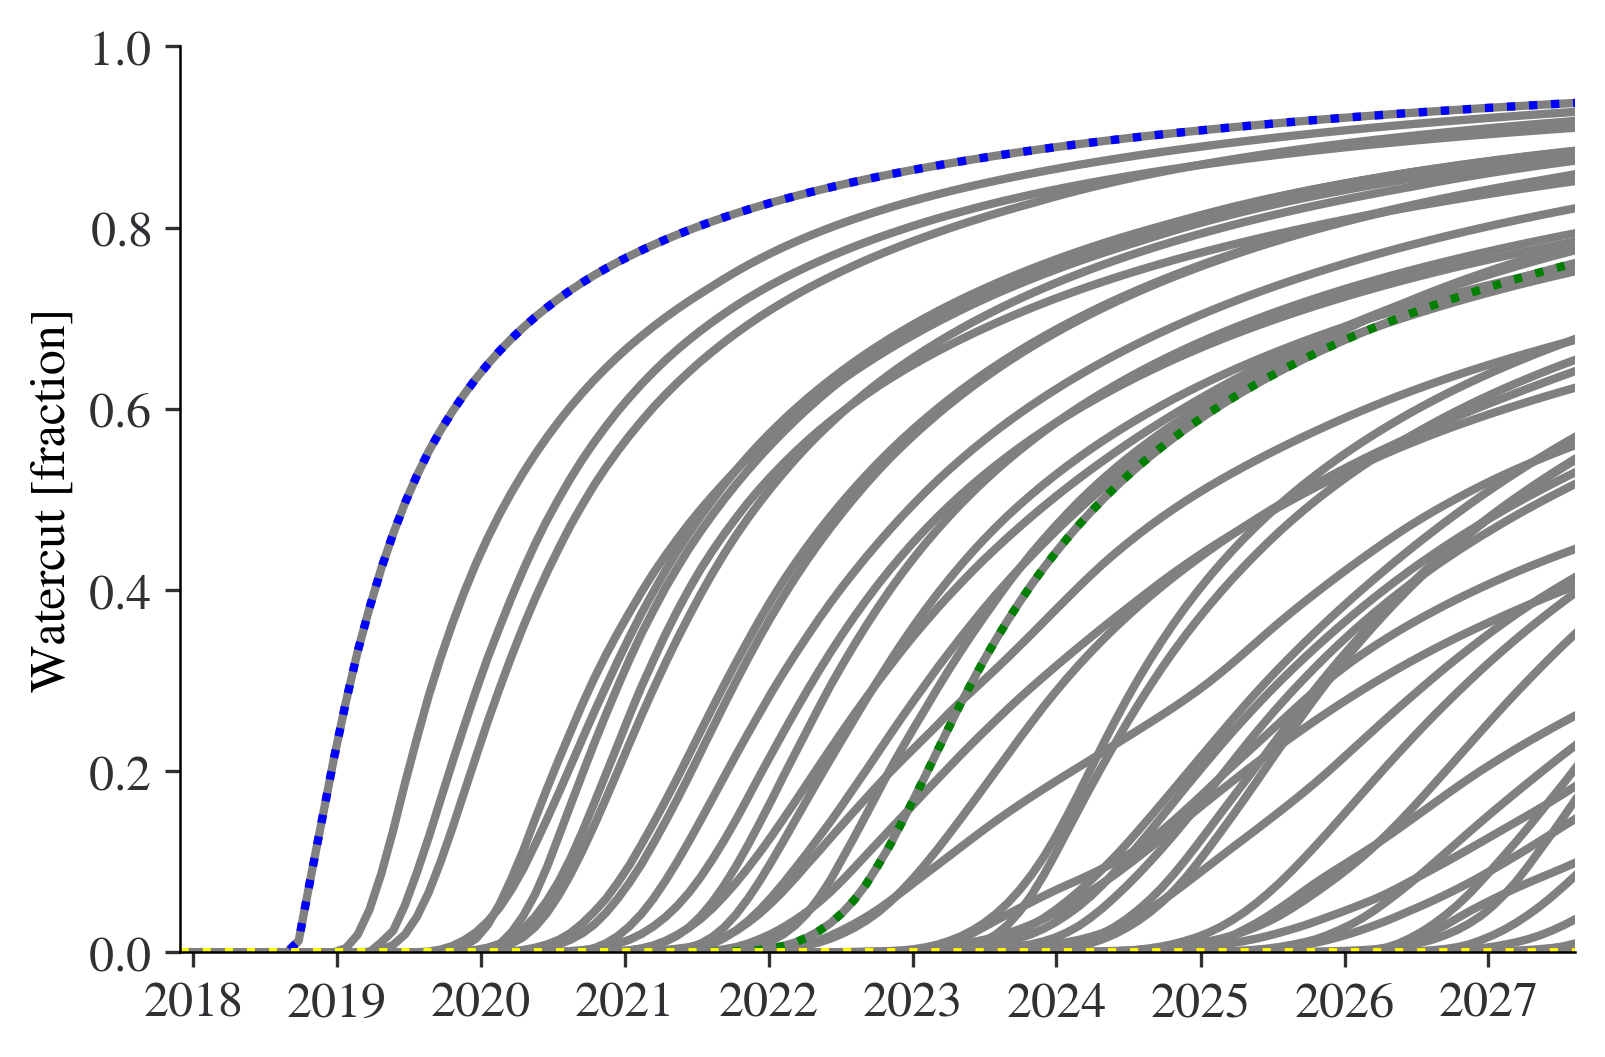

In [604]:
plt.plot(Date.Date,Watercut,"gray")
plt.plot(Date.Date,Watercut.Watercut_M27sdata_fraction,"red",linestyle = 'dotted',linewidth=2)
plt.plot(Date.Date,Watercut.Watercut_M65sdata_fraction,"blue",linestyle = 'dotted',linewidth=2)
plt.plot(Date.Date,Watercut.Watercut_M62sdata_fraction,"green",linestyle = 'dotted',linewidth=2)
plt.plot(Date.Date,Watercut.Watercut_M9sdata_fraction,"yellow",linestyle = 'dotted',linewidth=2)

plt.xlim(datetime.date(2017,11,30),datetime.date(2027,8,10))
plt.ylim(0)
plt.ylabel("Watercut [fraction]")
plt.savefig('Watercut.png', bbox_inches='tight',dpi = 300)


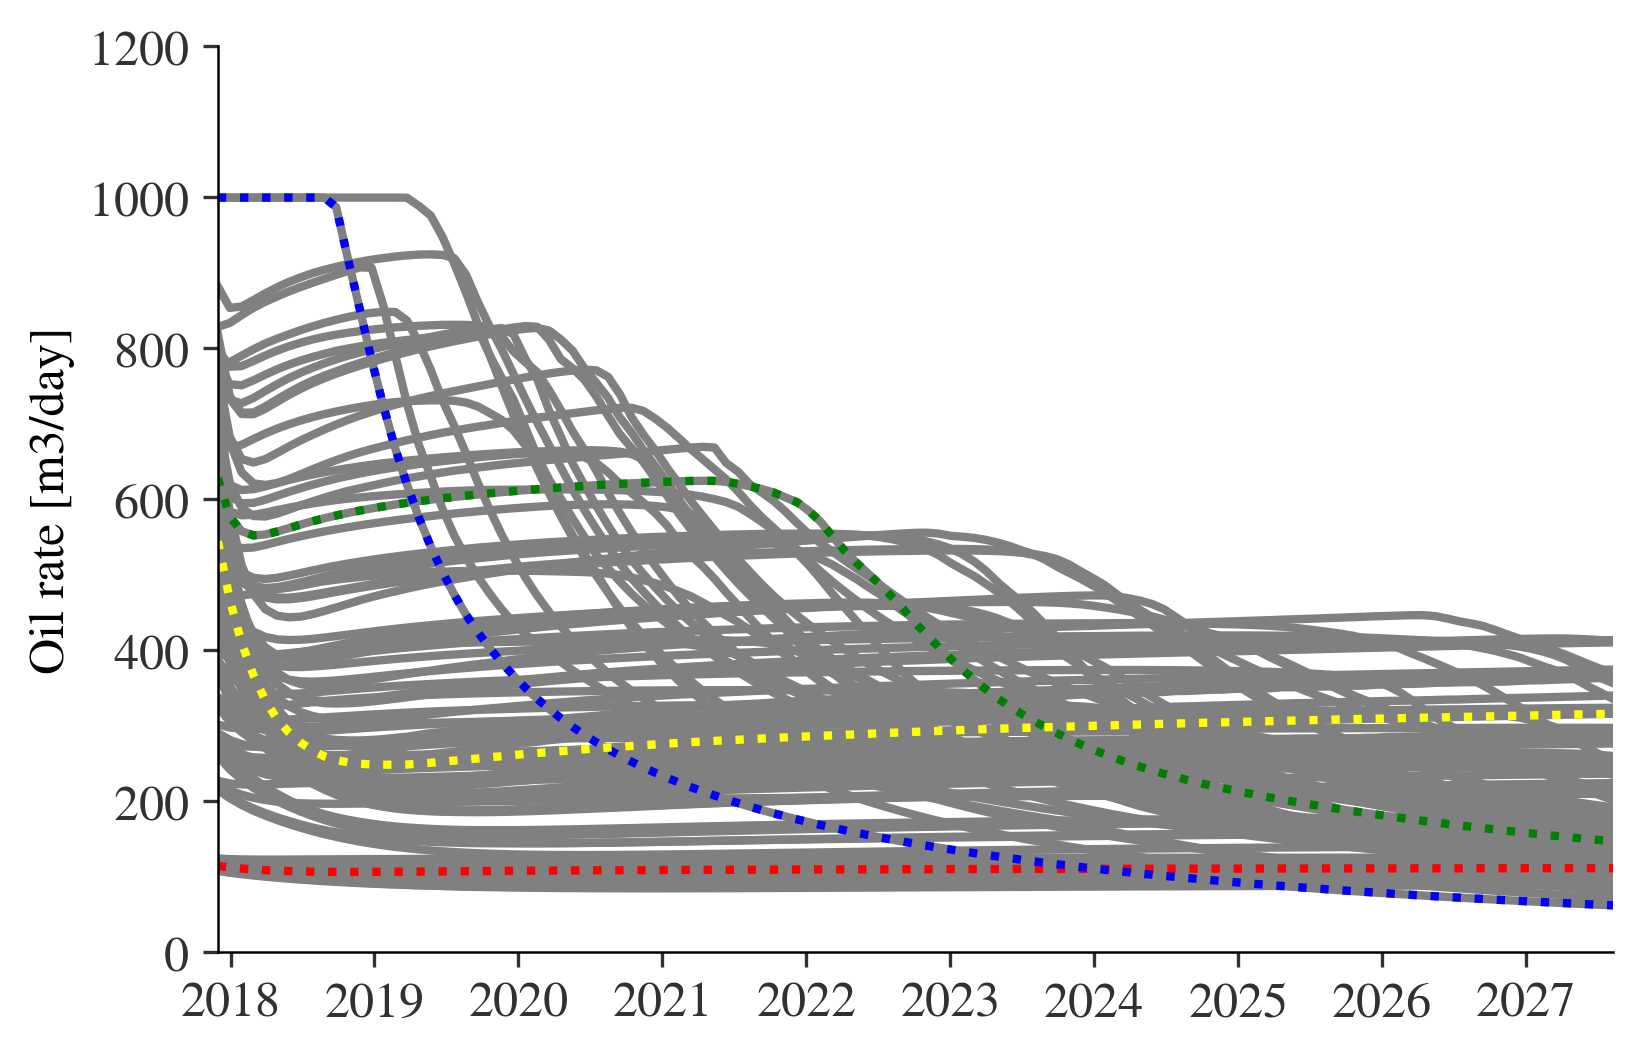

In [605]:
plt.plot(Date.Date,Oil_rate,"gray")
plt.plot(Date.Date,Oil_rate.OilRate_M27sdata_sm3day,"red",linestyle = 'dotted',linewidth=2)
plt.plot(Date.Date,Oil_rate.OilRate_M65sdata_sm3day,"blue",linestyle = 'dotted',linewidth=2)
plt.plot(Date.Date,Oil_rate.OilRate_M62sdata_sm3day,"green",linestyle = 'dotted',linewidth=2)
plt.plot(Date.Date,Oil_rate.OilRate_MTruth_Casesdata_sm3day,"yellow",linestyle = 'dotted',linewidth=2)

plt.xlim(datetime.date(2017,11,30),datetime.date(2027,8,10))
plt.ylim(0)
plt.ylabel("Oil rate [m3/day]")
plt.savefig('Oil_rate.png', bbox_inches='tight',dpi = 300)

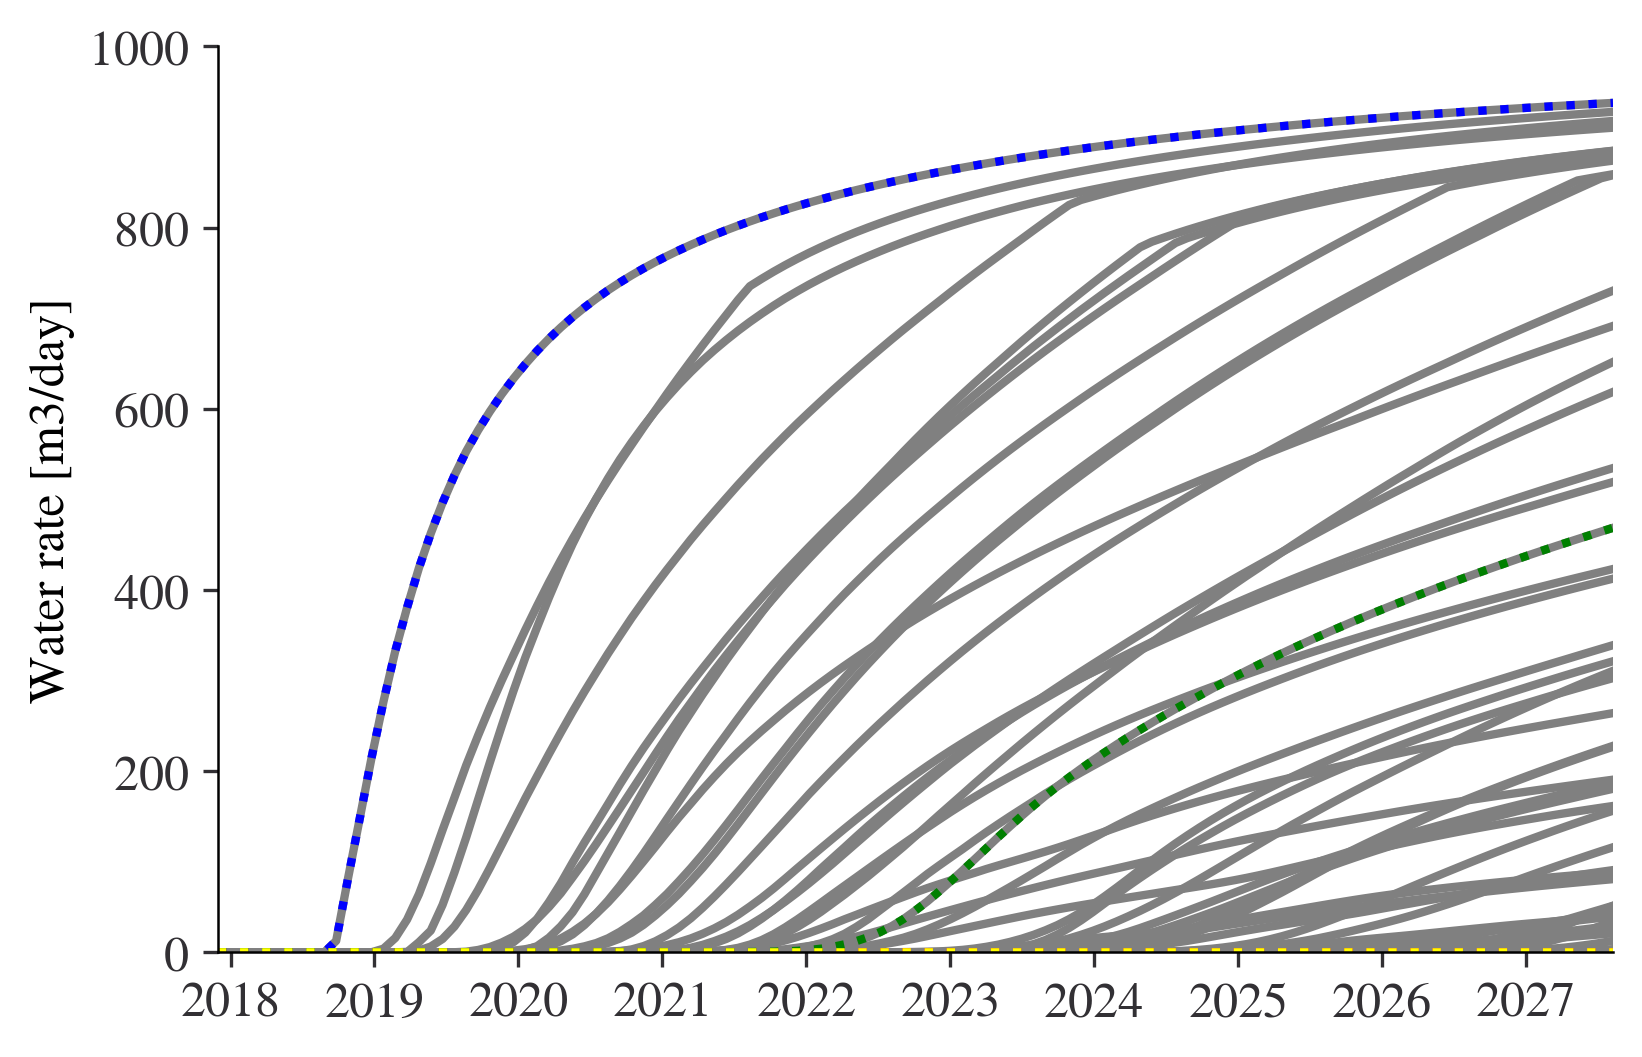

In [733]:
plt.plot(Date.Date,Water_rate,"gray")
plt.plot(Date.Date,Water_rate.WaterRate_M27sdata_sm3day,"red",linestyle = 'dotted',linewidth=2)
plt.plot(Date.Date,Water_rate.WaterRate_M65sdata_sm3day,"blue",linestyle = 'dotted',linewidth=2)
plt.plot(Date.Date,Water_rate.WaterRate_M62sdata_sm3day,"green",linestyle = 'dotted',linewidth=2)
plt.plot(Date.Date,Water_rate.WaterRate_MTruth_Casesdata_sm3day,"yellow",linestyle = 'dotted',linewidth=2)

plt.xlim(datetime.date(2017,11,30),datetime.date(2027,8,10))
plt.ylim(0)
plt.ylabel("Water rate [m3/day]")
plt.savefig('Water_rate.png', bbox_inches='tight',dpi = 300)

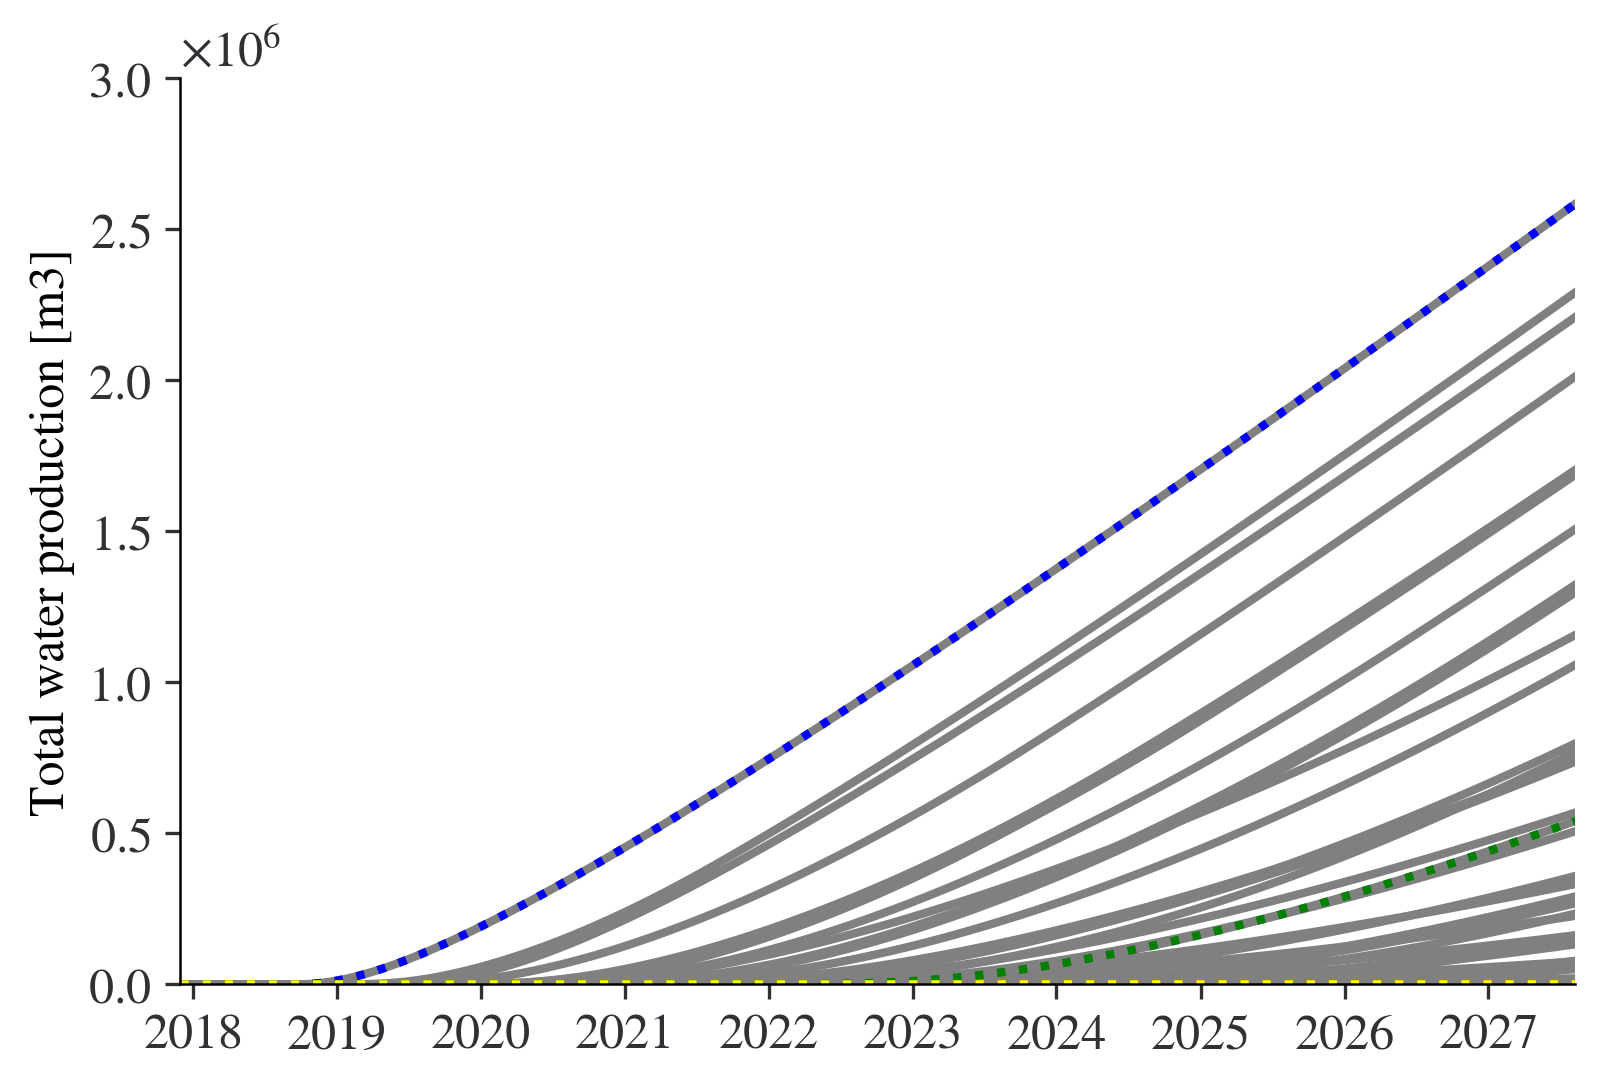

In [736]:
plt.plot(Date.Date,Water_total,"gray")
plt.plot(Date.Date,Water_total.WaterTotal_M27sdata_sm3,"red",linestyle = 'dotted',linewidth=2)
plt.plot(Date.Date,Water_total.WaterTotal_M65sdata_sm3,"blue",linestyle = 'dotted',linewidth=2)
plt.plot(Date.Date,Water_total.WaterTotal_M62sdata_sm3,"green",linestyle = 'dotted',linewidth=2)
plt.plot(Date.Date,Water_total.WaterTotal_MTruth_Casesdata_sm3,"yellow",linestyle = 'dotted',linewidth=2)
plt.ylim(0)
plt.xlim(datetime.date(2017,11,30),datetime.date(2027,8,10))
plt.ylabel("Total water production [m3]")
plt.savefig('Water_total.png', bbox_inches='tight',dpi = 300)

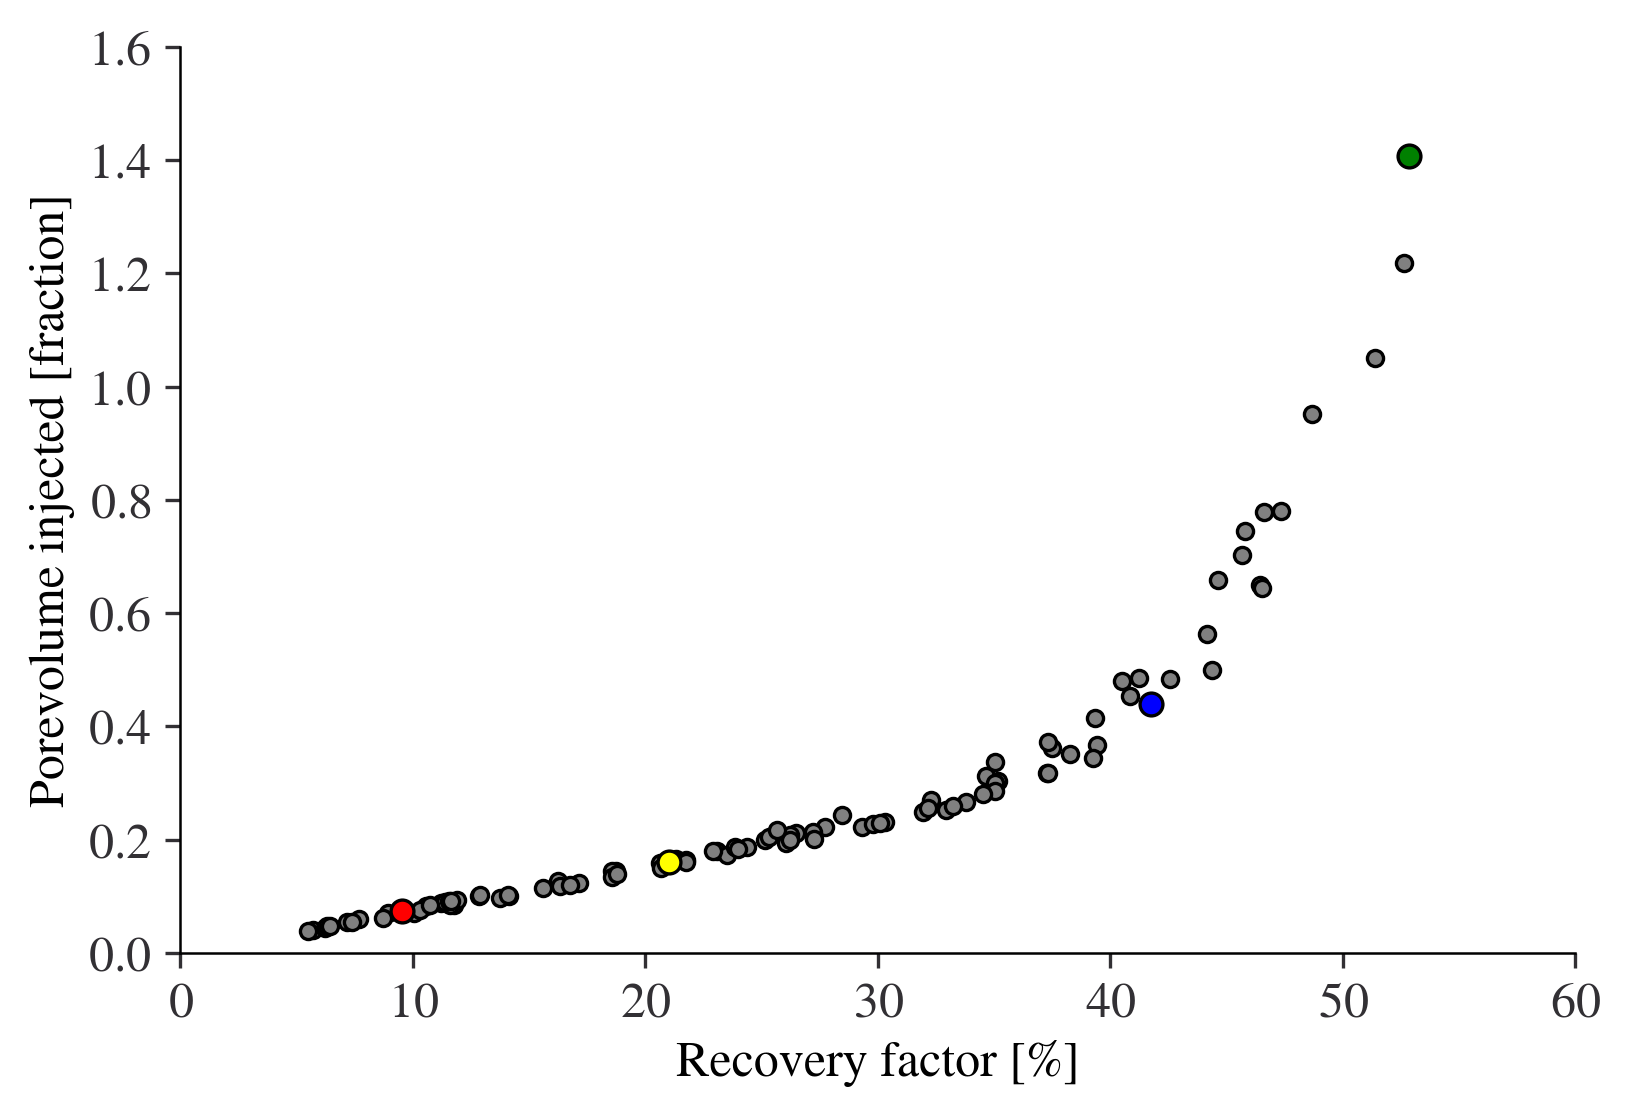

In [735]:

plt.scatter(OIP_start_end.loc['recovery_factor'],Porevolume_injected.loc[0],c = 'grey',s = 15)
plt.scatter(21,0.16,c = 'yellow',s = 30)
plt.scatter(OIP_start_end.CurrentOilinPlace_M27sdata_sm3.loc['recovery_factor'],Porevolume_injected.WaterInjectionTotal_M27sdata_sm3.loc[0],c = 'red',s = 30)
plt.scatter(OIP_start_end.CurrentOilinPlace_M62sdata_sm3.loc['recovery_factor'],Porevolume_injected.WaterInjectionTotal_M62sdata_sm3.loc[0],c = 'blue',s = 30)
plt.scatter(OIP_start_end.CurrentOilinPlace_M65sdata_sm3.loc['recovery_factor'],Porevolume_injected.WaterInjectionTotal_M65sdata_sm3.loc[0],c = 'green',s = 30)

plt.ylim(0)
plt.ylabel("Porevolume injected [fraction]")
plt.xlabel("Recovery factor [%]")

plt.savefig('PV_vs_injected_vol.png', bbox_inches='tight',dpi = 300)


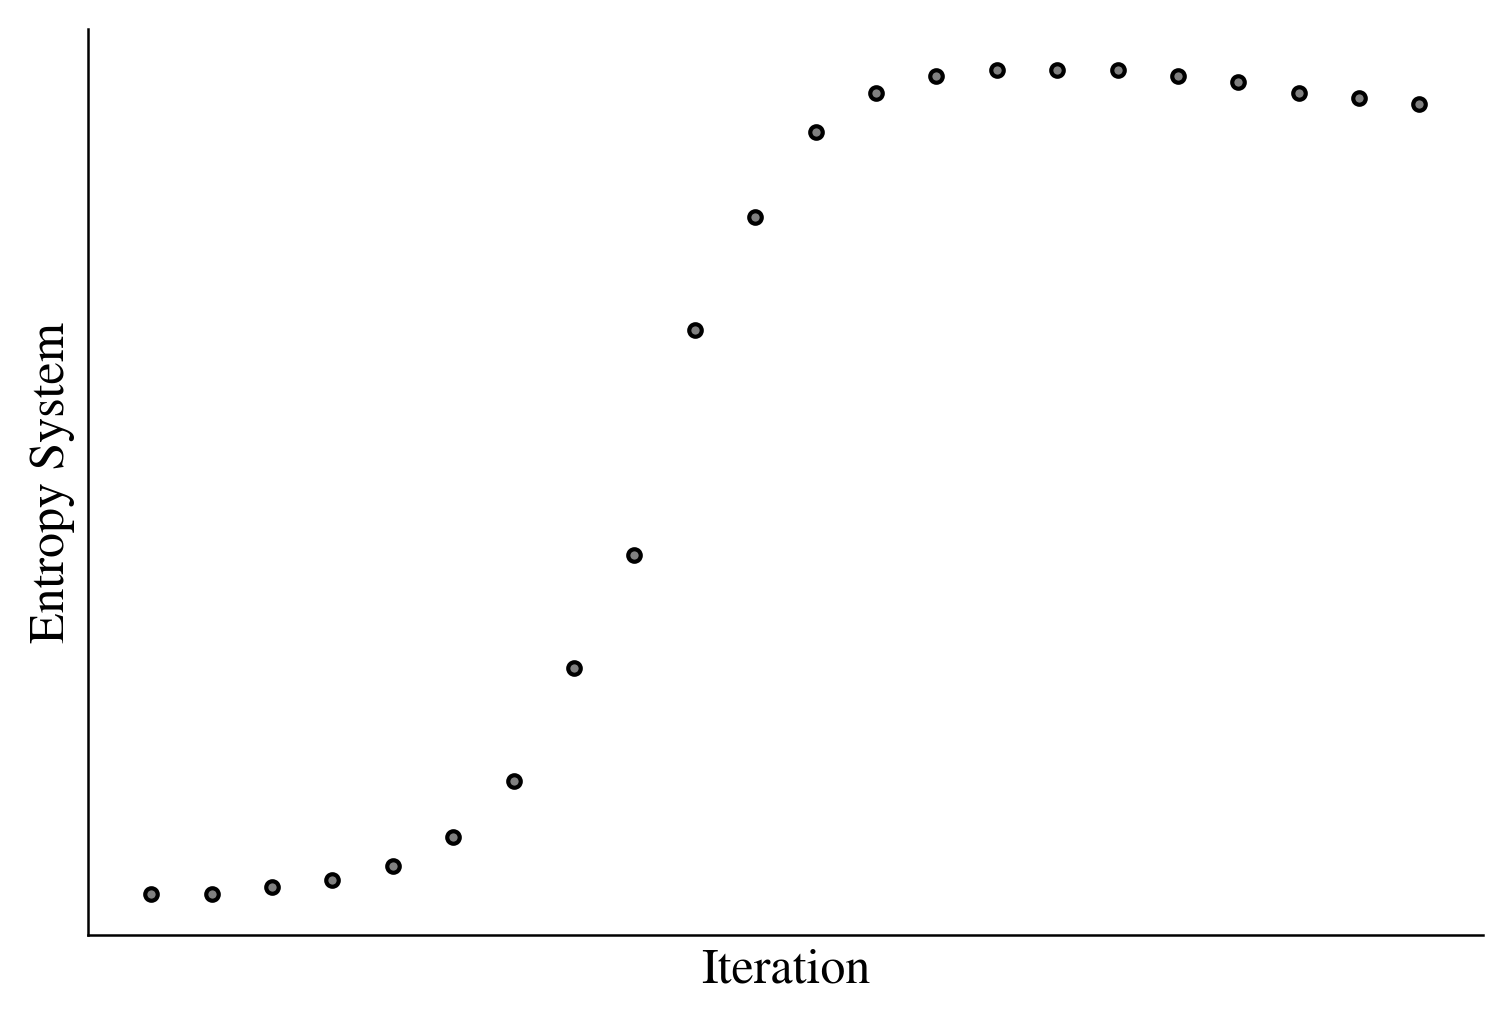

In [35]:
x = np.array([0,0,0.125,0.25,0.5,1,2,4,6,10,12,13.5,14.2,14.5,14.6,14.6,14.6,14.5,14.4,14.2,14.1,14])
plt.plot(x,".",c = 'grey')
plt.ylabel("Entropy System")
plt.xlabel("Iteration")
ax = plt.gca()
ax.axes.xaxis.set_ticks([])
ax.axes.yaxis.set_ticks([])

plt.grid(True)

plt.savefig('Entropy_sysetm.png', bbox_inches='tight',dpi = 300)


In [698]:
OIP_start_end.CurrentOilinPlace_MTruth_Casesdata_sm3

0                  4.967140e+06
120                3.886770e+06
recovery_factor    2.175034e+01
Name: CurrentOilinPlace_MTruth_Casesdata_sm3, dtype: float64

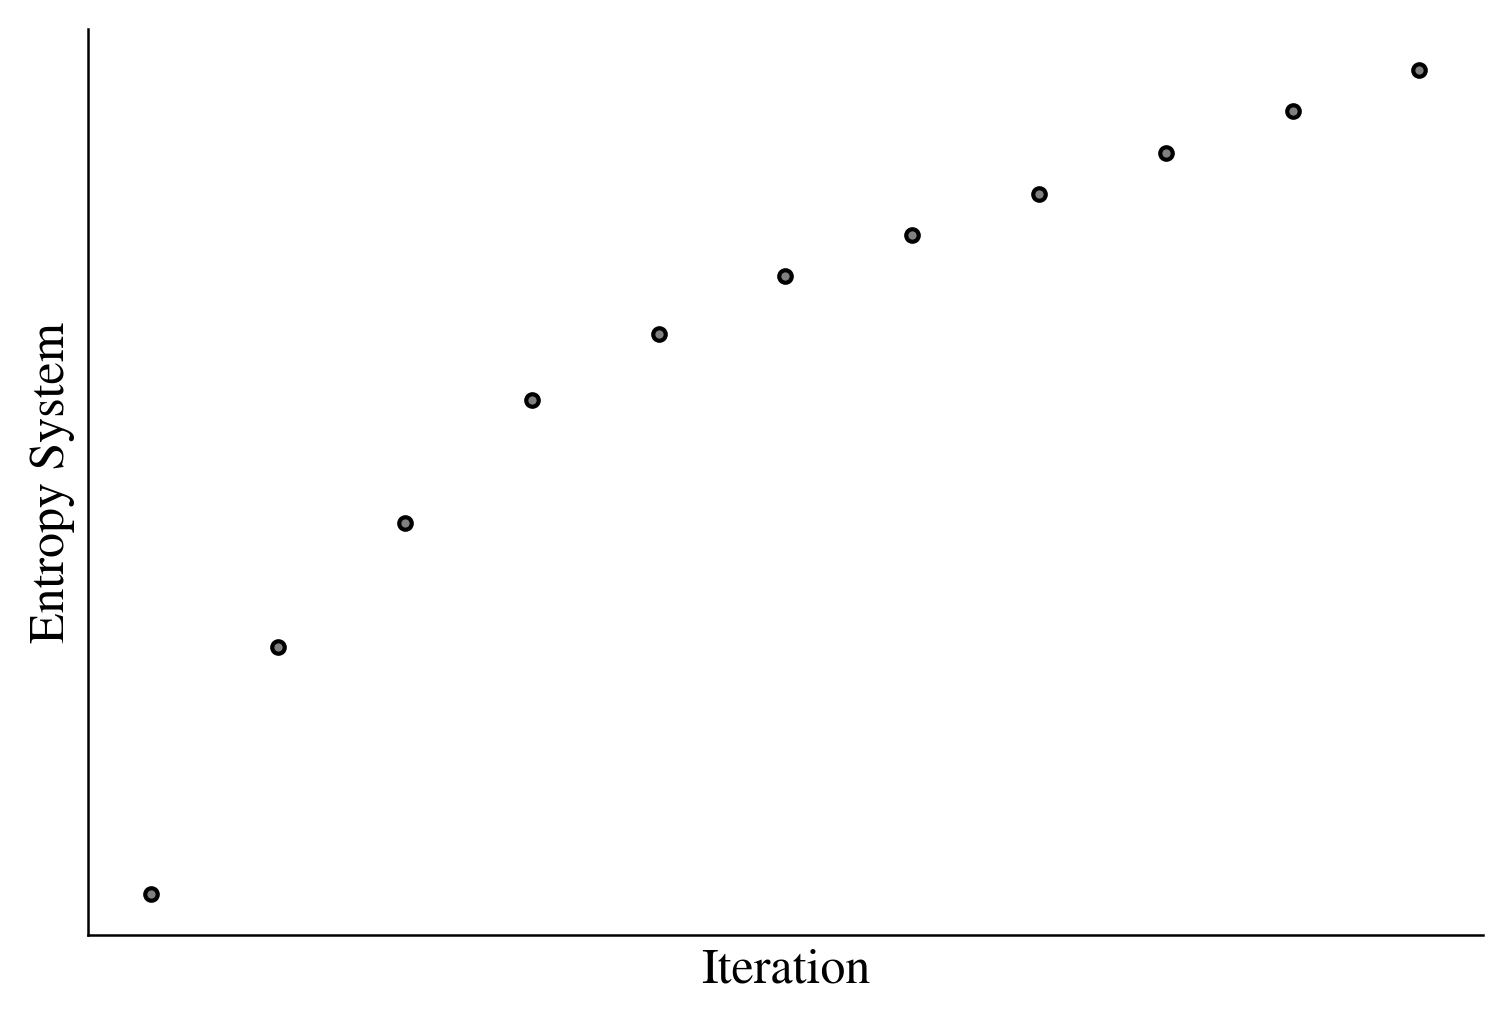

In [37]:
F_points_target = np.array([0, 0.3, 0.45, 0.6, 0.68, 0.75, 0.8, 0.85, 0.9, 0.95, 1])
plt.plot(F_points_target,".",c = 'grey')
plt.ylabel("Entropy System")
plt.xlabel("Iteration")
ax = plt.gca()
ax.axes.xaxis.set_ticks([])
ax.axes.yaxis.set_ticks([])

plt.grid(True)

plt.savefig('Entropy_sysetm.png', bbox_inches='tight',dpi = 300)